# Tutorial: Interactive Scenario Simulation

This tutorial explains how are the interactive scenarios simulated by coupling CommonRoad with [SUMO](https://sumo.dlr.de/docs/index.html) traffic simulator. Below, a scenario is referred to as **recorded** if all other traffic participants therein follow pre-recorded trajectories, whereas in an **interactive** scenario, those trajectories vary depending on the input trajectory of the ego vehicle. Currently supported options for interactive scenario simulation are:
  1. Simulation without an ego vehicle.
  2. Simulation with a plugged-in motion planner.
  3. Simulation with a solution trajectory to the planning problem.

In the following sections, you will be able to observe the varied behaviors of other traffic participants towards the motion of the ego vehicle. 

## 0. Preparation
Before you proceed with this tutorial, we assume that:
* you have gone through the tutorials on [CommonRoad Input-Output](https://commonroad.in.tum.de/tutorials/commonroad-interface) and have a basic understanding of the CommonRoad scenarios.
* you have successfully installed all necessary modules for the interactive benchmark by running the installation script.

Here, we import necessary packages for the simulation. Also, we specify some required path and parameters required for the simulation. As an example, we demonstrate the simulation with scenario `DEU_Frankfurt-34_10_I-1`, which is located under the folder `./interactive_scenarios`.

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
sys.path.append(os.path.join(os.getcwd(), "../"))

from simulation.simulations import simulate_without_ego, simulate_with_solution, simulate_with_planner
from simulation.utility import visualize_scenario_with_trajectory, save_solution
from commonroad.common.file_writer import CommonRoadFileWriter, OverwriteExistingFile
from commonroad.common.solution import CommonRoadSolutionReader, VehicleType, VehicleModel, CostFunction
from commonroad.scenario.scenario import Tag

path = os.path.abspath("")

# specify required arguments
name_scenario = "DEU_Frankfurt-34_10_I-1"
# replace with local folder path (in this case we cloned the whole repository from https://gitlab.lrz.de/tum-cps/commonroad-scenarios/-/tree/2020a_scenarios):
folder_scenarios = os.path.join(path, "interactive_scenarios")
path_scenario = os.path.join(folder_scenarios, name_scenario)
# path where solutions are stored
path_solutions = os.path.join(path, "../outputs/solutions")

# path to store output video
path_video = os.path.join(path, "../outputs/videos")

# path to store simulated scenarios
path_scenarios_simulated = os.path.join(path, "../outputs/simulated_scenarios")

# demo attributes for saving the simualted scenarios
author = 'Max Mustermann'
affiliation = 'Technical University of Munich, Germany'
source = ''
tags = {Tag.URBAN}

vehicle_type = VehicleType.FORD_ESCORT
vehicle_model = VehicleModel.KS
cost_function = CostFunction.TR1

## 1. Simulation without an Ego Vehicle

As the start, we demonstrate how to run the simulation in SUMO without considering the ego vehicle. This is beneficial for observing the default behaviour of other traffic participants. The simulation is executed by calling the function **simulate_without_ego()** with the following arguments:
* **interactive_scenario_path**: path to the folder containing required SUMO network files for the sceanrio. 
* **output_folder_path**: path to the output folder.
* **create_video**: indicates whether to create a video of the simulated scenario. **Default value**: False

We save the simulated scenario to a local CommonRoad xml file.

Note: it is alright if you see some SUMO simulation-related warnings.

In [2]:
# run simulation, a video animation of the simulation is stored in the end
scenario_without_ego, pps = simulate_without_ego(interactive_scenario_path=path_scenario,
                                                 output_folder_path=path_video,
                                                 create_video=False)
# write simulated scenario to CommonRoad xml file
fw = CommonRoadFileWriter(scenario_without_ego, pps, author, affiliation, source, tags)
fw.write_to_file(f"{path_scenarios_simulated}{name_scenario}_no_ego.xml", OverwriteExistingFile.ALWAYS)

 Retrying in 1 seconds
Replace file /home/klischat/GIT_REPOS/commonroad-interactive-scenarios/tutorials/../outputs/simulated_scenariosDEU_Frankfurt-34_10_I-1_no_ego.xml


## 2. Simulation with a Plugged-in Motion Planner

Naturally, we would like to test the performance of our motion planners against the interactive scenarios. This is possible thanks to the [CR-SUMO Interface](https://gitlab.lrz.de/tum-cps/commonroad-sumo-interface), which provides an easy-to-use interface for retrieving and setting the states of the ego vehicles during SUMO simulation.

The simulation is executed by calling the function **simulate_with_planner()**. It has the same arguments as **simulate_without_ego()**, with one extra optional argument:
* **create_ego_obstacle**: indicates whether to create obstacles from the planned trajectories as the ego vehicles.

The motion planner is plugged in at `simulation/simulations.py/simulate_scenario()`. A demo planner is given in lines 134-146, which simply decelerates the ego vehicle to full stop:
```python
next_state = copy.deepcopy(state_current_ego)
# ====== plug in your motion planner here
# example motion planner which decelerates to full stop
a = -5.0
dt = 0.1
if next_state.velocity > 0:
    v = next_state.velocity
    x, y = next_state.position
    o = next_state.orientation

    next_state.position = np.array([x + v * cos(o) * dt, y + v * sin(o) * dt])
    next_state.velocity += a * dt
# ====== end of motion planner
```

We save the simulated scenario to a local CommonRoad xml file. Optionally, we can also save the planned trajectory to a solution file.

In [3]:
# run simulation, an animation of the simulation is stored in the end
scenario_with_planner, pps, ego_vehicles_planner = simulate_with_planner(interactive_scenario_path=path_scenario,
                                                                         output_folder_path=path_video,
                                                                         create_video=False)

 Retrying in 1 seconds


In [4]:
# write simulated scenario to CommonRoad xml file
if scenario_with_planner:
    # write simulated scenario to file
    fw = CommonRoadFileWriter(scenario_with_planner, pps, author, affiliation, source, tags)
    fw.write_to_file(f"{path_scenarios_simulated}{name_scenario}_planner.xml", OverwriteExistingFile.ALWAYS)
    
    # save the planned trajectory to solution file
    save_solution(scenario_with_planner, pps, ego_vehicles_planner, vehicle_type, vehicle_model, cost_function,
                  path_solutions, overwrite=True)

Replace file /home/klischat/GIT_REPOS/commonroad-interactive-scenarios/tutorials/../outputs/simulated_scenariosDEU_Frankfurt-34_10_I-1_planner.xml
Trajectory saved to solution file.


## 3. Simulation with a Solution Trajectory

Provided that we have a solution trajectory to the interactive scenario, we can easily replay and re-simulate the scenario.

The simulation is executed by calling the function **simulate_with_solution()**. It has the same arguments as **simulate_without_ego()**, with one extra mandatory argument:
* **solution**: solution file to the planning problem.

Here, we re-simualte the scenario with a pre-computed solution trajectory.

In [5]:
name_solution = "solution_KS1:TR1:DEU_Frankfurt-34_10_I-1:2020a"
solution = CommonRoadSolutionReader.open(os.path.join(path_solutions, name_solution + ".xml"))

In [6]:
# run simulation, a video of the simulation is stored in the end
scenario_with_solution, pps, ego_vehicles_solution = simulate_with_solution(interactive_scenario_path=path_scenario,
                                                                            output_folder_path=path_video,
                                                                            solution=solution,
                                                                            create_video=False)
# write simulated scenario to CommonRoad xml file
if scenario_with_solution:
    # write simulated scenario to file
    fw = CommonRoadFileWriter(scenario_with_solution, pps, author, affiliation, source, tags)
    fw.write_to_file(f"{path_scenarios_simulated}{name_scenario}_solution.xml", OverwriteExistingFile.ALWAYS)

 Retrying in 1 seconds
Replace file /home/klischat/GIT_REPOS/commonroad-interactive-scenarios/tutorials/../outputs/simulated_scenariosDEU_Frankfurt-34_10_I-1_solution.xml


## 4. Examining the Simulation Results

Now, it's time to examine and compare the simulation results. A helper function **visualize_scenario_with_trajectory()** is called to animate the scenario. 

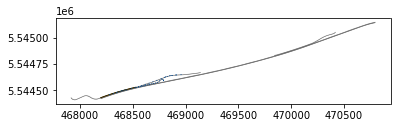

In [7]:
%matplotlib inline
visualize_scenario_with_trajectory(scenario_without_ego, pps)

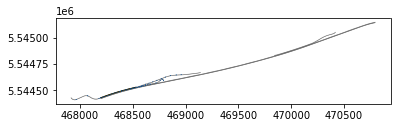

In [8]:
visualize_scenario_with_trajectory(scenario_with_planner, pps, ego_vehicles_planner)

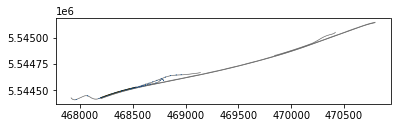

In [9]:
visualize_scenario_with_trajectory(scenario_with_solution, pps, ego_vehicles_solution)

As can be seen from the animation, when the ego vehicle (green rectangle) is present, the other traffic participants behave differently and react accordingly. To better compare the scenarios, you can find the created video files under `/outputs/videos/`, and saved scenarios under `/outputs/simulated/`.